<a href="https://colab.research.google.com/github/uscmlsystems/ee508-sp26-hw2-ichen522/blob/main/files/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EE 508 HW 2: Convolution Neural Network

Your task in this Colab notebook is to fill out the sections that are specified by **TODO** (please search the keyword `TODO` to make sure you do not miss any).

Prerequisites: set the runtime type to GPU. (Runtime -> Change Runtime Type)

In [2]:
#%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader


Verify that GPU is availble to use.

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print("Device", device)

Device cuda


## Convolution

Definition:
Convolution is a mathematical operation where a filter (or kernel) is applied over an input (e.g., image) to produce a modified output known as a feature map.

Key Components:
- Kernel/Filter: A small matrix that slides over the input. It captures patterns or features from the input.
  
- Stride: The number of pixels the filter moves at each step.
  
- Padding: Zeros added around the input's border, often used to control the output's spatial dimensions.

Operation:
The filter starts at the top-left corner of the image. For each position, values under the filter are multiplied with its corresponding filter values, then summed to produce a single pixel in the output. This process is repeated across the entire input.

## Create a sample image

Create a 3D  `image` of shape `(1,10,10)` as a numpy-array. The signal values are 1 (white) in the `(4,4)`-center region and 0 (black) elsewhere.

Plot the image as a grid with black or white colors and write the 0 or 1 value on each cell.

In [4]:
# Create a 1x10x10 image filled with zeros
image = np.zeros((1, 10, 10), dtype=np.float32)

# Set a 4x4 sub-matrix (starting from index 3 to 7 both for rows and columns) to be filled with ones
image[0, 3:7, 3:7] = 1

# Print the formatted matrix
print(image)
print(image.shape)

[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
  [0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
  [0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
  [0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]
(1, 10, 10)


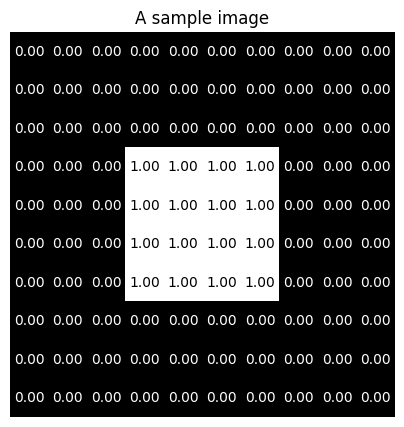

In [5]:
def plot_image_with_values(image, title):
    """
    Plots a 3D image with numeric values overlaid on each cell.

    Parameters:
    - image (3D numpy array): The image to be plotted.
    - title (str): The title of the plot.
    """
    plt.figure(figsize=(5,5))

    # Plot the image
    plt.imshow(image[0], cmap='gray')

    # Looping through all cells to overlay the numeric values
    for i in range(image.shape[1]):
        for j in range(image.shape[2]):
            pixel_value = image[0, i, j]
            text_color = 'white' if pixel_value < 0.5 else 'black'  # Setting text color based on pixel value
            plt.text(j, i, f'{pixel_value:.2f}', ha='center', va='center', color=text_color)

    plt.title(title)
    plt.axis('off')
    plt.show()


plot_image_with_values(image, 'A sample image')

## Average Filter

### **TODO 1**:
Implement a function that applies a 3x3 average filter to an input image using PyTorch's [conv2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html) function. The filter should have all values set to 1/9, ensuring the sum is 1, and use a padding of 1 to keep the output image dimensions the same as the input.

Note that the input and output of the `average_filter` function are numpy array type, so you need to convert numpy array to pytorch tensor, process the tensor, and convert pytorch tensor back to numpy array.

In [6]:
# Skeleton for TODO 1


def average_filter(image):
    """
    Apply a 3x3 average filter to the input image using PyTorch and return the filtered image.

    Args:
    - image: A 3D numpy array representing the input image.

    Returns:
    - filtered_img: A 3D numpy array representing the image after applying the filter.
    """

    # 1. Convert image to a PyTorch tensor
    # Assuming the input numpy array is (Height, Width, Channels)
    # Convert to float32 (required for conv2d) and transform to PyTorch format
    tensor_img = torch.from_numpy(image).float()

    # Permute to (Channels, Height, Width) and add a batch dimension -> (1, C, H, W)
    tensor_img = tensor_img.permute(2, 0, 1).unsqueeze(0)

    # Get the number of channels (C)
    C = tensor_img.shape[1]

    # 2. Define a 3x3 average filter with all values set to 1/9
    # We want a depthwise filter so it applies to each channel independently.
    # The weight shape for this is: (out_channels, in_channels/groups, kernel_H, kernel_W)
    # which evaluates to (C, 1, 3, 3)
    kernel = torch.ones((C, 1, 3, 3), dtype=torch.float32) / 9.0

    # 3. Apply conv2d with padding=1
    # Setting groups=C forces the convolution to process each channel separately
    filtered_tensor = F.conv2d(tensor_img, kernel, padding=1, groups=C)

    # 4. Convert back to numpy
    # Remove the batch dimension (squeeze) and permute back to (Height, Width, Channels)
    filtered_img = filtered_tensor.squeeze(0).permute(1, 2, 0).numpy()

    # (Optional) Cast back to the original numpy data type (e.g., uint8)
    filtered_img = filtered_img.astype(image.dtype)

    return filtered_img

Plot the image as a grid with black or white colors and write the 0 or 1 value on each cell.

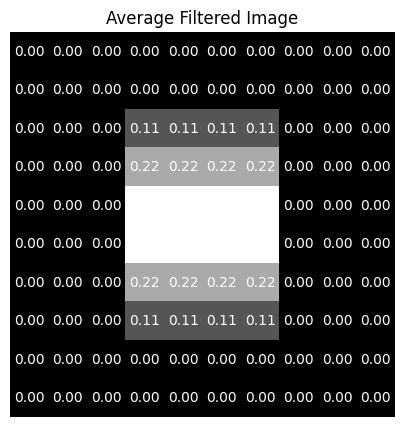

In [7]:
filtered_img = average_filter(image)
plot_image_with_values(filtered_img, 'Average Filtered Image')

## Edge Detection

In image processing, edge detection refers to the process of identifying abrupt changes or discontinuities in an image. These abrupt changes often correspond to object boundaries, textures, or other significant features.

The concept of **central differences** can be applied to images to detect edges by estimating the gradient magnitude at each pixel. In the context of images, the derivative approximations can highlight the areas of rapid intensity change, which are often the edges.

Using the concept of central differences, one possible filter for vertical edge detection is:
\begin{bmatrix}
-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1 \\
\end{bmatrix}

### **TODO 2**:
Implement a function that applies a 3x3 vertical edge detection filter to an input image using PyTorch's [conv2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html) function.

In [8]:

def vertical_edge_detection(image):
    """
    Applies a 3x3 vertical edge detection filter to an input image using PyTorch.

    Args:
        - image: A 3D numpy array representing the input image (H, W, C).

    Returns:
        - filtered_img: A 3D numpy array of the filtered image.
    """

    # 1. Convert numpy image to PyTorch tensor
    # Cast to float32 and permute dimensions: (H, W, C) -> (C, H, W)
    # Then add a batch dimension: (1, C, H, W) to match PyTorch's NCHW format
    tensor_img = torch.from_numpy(image).float()
    tensor_img = tensor_img.permute(2, 0, 1).unsqueeze(0)

    # Get the number of input channels (C)
    C = tensor_img.shape[1]

    # 2. Define the Vertical Edge Detection Filter (Prewitt/Sobel-style)
    # The filter identifies intensity changes from left to right.
    base_filter = torch.tensor([[-1.,  0.,  1.],
                                [-1.,  0.,  1.],
                                [-1.,  0.,  1.]], dtype=torch.float32)

    # Reshape to (1, 1, 3, 3) and repeat C times to get shape (C, 1, 3, 3).
    # This configuration is required for Depthwise Convolution (groups=C).
    kernel = base_filter.view(1, 1, 3, 3).repeat(C, 1, 1, 1)

    # 3. Apply 2D Convolution with padding=1 to maintain spatial resolution
    # Setting groups=C ensures each channel is convolved independently
    # with its own corresponding kernel slice.
    filtered_tensor = F.conv2d(tensor_img, kernel, padding=1, groups=C)

    # 4. Convert back to numpy array
    # Remove batch dimension and permute back to (H, W, C) for standard image processing
    filtered_img = filtered_tensor.squeeze(0).permute(1, 2, 0).numpy()

    # Note: Edge detection results in negative values where transitions are opposite.
    # For visualization, np.abs() or normalization is typically applied.

    return filtered_img

## Applying Filters on an Actual Image

In this section we apply several filters on an actual image.

Use `PIL` library to read a image from online resource called `sheep.jpg` as a numpy array. Convert that image to grayscale so that it only has a single channel and plot the image.

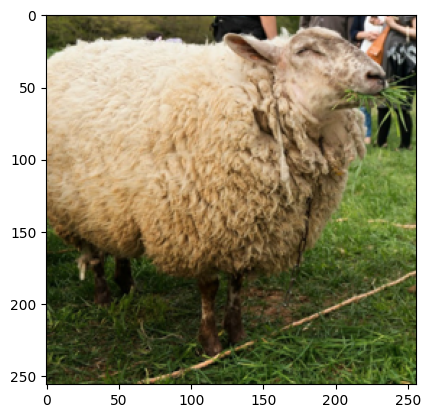

In [9]:
from PIL import Image
import urllib.request

image = Image.open(urllib.request.urlopen('https://chokkan.github.io/deeplearning/assets/images/sheep.jpg'))
image = image.resize((256, 256))  # resize image.
plt.imshow(image)

image = image.convert('L')  # convert to grey scale
image = np.array(image, dtype=np.float32) / 255  # normalize image to range [0, 1]
image = np.expand_dims(image, axis=0)  # expand to 3 dimensional

Create a function that can plot both the original image and its modified version side by side.

In [10]:
def plot_original_and_modified(original_img, modified_img):
    """
    Plot the original image and its modified version side by side.

    Args:
    - original_img: A 3D numpy array representing the original image.

    - modified_img: A 3D numpy array representing the the modified version of the original image.
    """

    # Ensure that the input arrays are in the range [0, 1]
    original_img = np.clip(original_img, 0, 1)[0]
    modified_img = np.clip(modified_img, 0, 1)[0]

    plt.figure(num=None, figsize=(12,12), dpi=80, facecolor='w', edgecolor='k')

    # Plot the original image
    plt.subplot(1,2,1)
    plt.imshow(original_img, cmap='Greys_r')
    plt.title("Original Image")

    # Plot the modified image
    plt.subplot(1,2,2)
    plt.imshow(modified_img, cmap='Greys_r')
    plt.title("Modified Image")

    plt.show()

Apply the `vertical_edge_detection` funtion implemented above to the image.

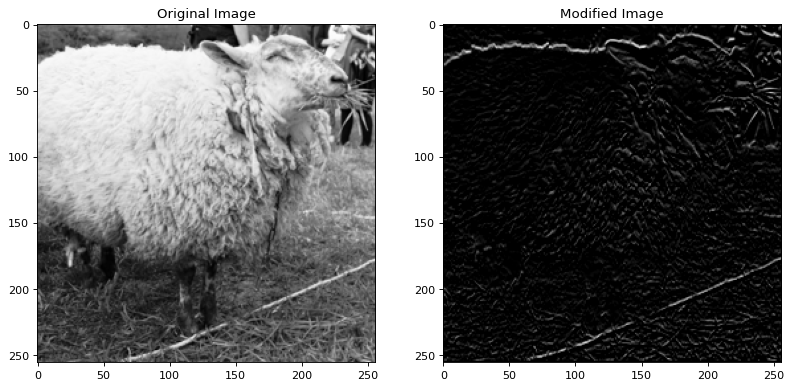

In [11]:
filtered_img = vertical_edge_detection(image)
plot_original_and_modified(image, filtered_img)

### **TODO 3:**
Implement a function that applies a 3x3 **horizontal** edge detection filter to an input image using PyTorch's [conv2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html) function. What should the filter be in this case?

In [12]:
def horizontal_edge_detection(image):
    """
    Applies a 3x3 horizontal edge detection filter to an input image using PyTorch.

    Args:
        - image: A 3D numpy array representing the input image (H, W, C).

    Returns:
        - filtered_img: A 3D numpy array of the filtered image.
    """

    # 1. Convert numpy image to PyTorch tensor
    # Cast to float32 and permute dimensions: (H, W, C) -> (C, H, W)
    # Then add a batch dimension: (1, C, H, W) to match PyTorch's NCHW format
    tensor_img = torch.from_numpy(image).float()
    tensor_img = tensor_img.permute(2, 0, 1).unsqueeze(0)

    # Get the number of input channels (C)
    C = tensor_img.shape[1]

    # 2. Define the Horizontal Edge Detection Filter (Sobel/Prewitt style)
    # This detects intensity differences between the top and bottom rows.
    base_filter = torch.tensor([[-1., -1., -1.],
                                [ 0.,  0.,  0.],
                                [ 1.,  1.,  1.]], dtype=torch.float32)

    # Reshape to (1, 1, 3, 3) and repeat C times to get shape (C, 1, 3, 3).
    # This satisfies the requirement for Depthwise Convolution (groups=C).
    kernel = base_filter.view(1, 1, 3, 3).repeat(C, 1, 1, 1)

    # 3. Apply 2D Convolution with padding=1 to maintain spatial resolution
    # Setting groups=C ensures each channel is processed independently.
    filtered_tensor = F.conv2d(tensor_img, kernel, padding=1, groups=C)

    # 4. Convert back to numpy array
    # Remove batch dimension and permute back to (H, W, C) for standard image processing.
    filtered_img = filtered_tensor.squeeze(0).permute(1, 2, 0).numpy()

    return filtered_img

### **TODO 4:**
Lapalacian filters can increase the regions of the image with rapid intensity. It is very helpful in hiding the fine details of images. Any features with a sharp discontunioty will be enhanced.

One of the Laplacian filter is

\begin{bmatrix}
 0 & -1 &  0 \\
-1 &  5 & -1 \\
 0 & -1 &  0 \\
\end{bmatrix}


Implement a function that applies a 3x3 laplacian filter to an input image using PyTorch's [conv2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html) function.

In [13]:
def laplacian_filter(image):
    """
    Applies a 3x3 Laplacian (sharpening) filter to an input image using PyTorch.

    Args:
        - image: A 3D numpy array representing the input image (H, W, C).

    Returns:
        - filtered_img: A 3D numpy array of the filtered image.
    """

    # 1. Convert numpy image to PyTorch tensor
    # Cast to float32 and permute dimensions: (H, W, C) -> (C, H, W)
    # Then add a batch dimension: (1, C, H, W) for PyTorch NCHW format
    tensor_img = torch.from_numpy(image).float()
    tensor_img = tensor_img.permute(2, 0, 1).unsqueeze(0)

    # Get the number of input channels (C)
    C = tensor_img.shape[1]

    # 2. Define the Laplacian Sharpening Filter
    # This kernel enhances central pixels relative to their neighbors.
    base_filter = torch.tensor([[ 0., -1.,  0.],
                                [-1.,  5., -1.],
                                [ 0., -1.,  0.]], dtype=torch.float32)

    # Reshape to (1, 1, 3, 3) and repeat C times to create (C, 1, 3, 3)
    # This prepares the kernel for Depthwise Convolution (groups=C)
    kernel = base_filter.view(1, 1, 3, 3).repeat(C, 1, 1, 1)

    # 3. Apply 2D convolution with padding=1 to keep output dimensions identical
    # groups=C ensures each color channel is processed independently
    filtered_tensor = F.conv2d(tensor_img, kernel, padding=1, groups=C)

    # 4. Convert back to numpy array
    # Squeeze the batch dimension and permute back to (H, W, C)
    filtered_img = filtered_tensor.squeeze(0).permute(1, 2, 0).numpy()

    # Note: Filtering can result in values outside the 0-255 range.
    # For visualization, np.clip(filtered_img, 0, 255) is usually required.

    return filtered_img

### **TODO 5:**

The Gaussian filter is commonly used for blurring image. Its values are determined by the Gaussian function, resulting in a weighted average that emphasizes the central pixel and decreases the influence of neighboring pixels as the distance increases.

The specific weights for the 3x3 Gaussian filter are arranged as follows, ensuring that the sum of all weights is equal to 1, which preserves the overall brightness of the image:

\begin{bmatrix}
1/16 & 2/16 & 1/16 \\
2/16 & 4/16 & 2/16 \\
1/16 & 2/16 & 1/16 \\
\end{bmatrix}

This arrangement of weights creates a bell-shaped curve, centralizing the focus on the middle pixel while progressively giving less importance to pixels further away.

Implement a function that applies a 3x3 gaussian filter to an input image using PyTorch's [conv2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html) function.

In [14]:

def gaussian_filter(image):
    """
    Applies a 3x3 Gaussian blur filter to an input image using PyTorch.

    Args:
        - image: A 3D numpy array representing the input image (H, W, C).

    Returns:
        - filtered_img: A 3D numpy array of the blurred image.
    """

    # 1. Convert numpy image to PyTorch tensor
    # Cast to float32 and permute dimensions: (H, W, C) -> (C, H, W)
    # Then add a batch dimension: (1, C, H, W) for PyTorch NCHW format
    tensor_img = torch.from_numpy(image).float()
    tensor_img = tensor_img.permute(2, 0, 1).unsqueeze(0)

    # Get the number of input channels (C)
    C = tensor_img.shape[1]

    # 2. Define the Gaussian Filter Kernel
    # The weights sum to 1.0 to preserve the overall brightness of the image.
    base_filter = torch.tensor([[1/16, 2/16, 1/16],
                                [2/16, 4/16, 2/16],
                                [1/16, 2/16, 1/16]], dtype=torch.float32)

    # Reshape to (1, 1, 3, 3) and repeat C times to create (C, 1, 3, 3)
    # This prepares the kernel for Depthwise Convolution (groups=C)
    kernel = base_filter.view(1, 1, 3, 3).repeat(C, 1, 1, 1)

    # 3. Apply 2D convolution with padding=1 to maintain spatial resolution
    # groups=C ensures each color channel (R, G, B) is blurred independently
    filtered_tensor = F.conv2d(tensor_img, kernel, padding=1, groups=C)

    # 4. Convert back to numpy array
    # Squeeze the batch dimension and permute back to (H, W, C)
    filtered_img = filtered_tensor.squeeze(0).permute(1, 2, 0).numpy()

    # Cast the data type back to the original (e.g., uint8) to match the input
    filtered_img = filtered_img.astype(image.dtype)

    return filtered_img

## Pooling

Pooling is an operation frequently used in the context of Convolutional Neural Networks (CNNs) for image processing. The main idea behind pooling is to reduce the spatial size of the representation, thereby reducing the number of parameters and computational complexity in the network. This helps in making the network less prone to overfitting and also reduces computation time.

There are several types of pooling operations, with the most common ones being:

**Max Pooling**: In this method, for each segment of the input, the maximum value is selected. For instance, if we consider a 2x2 pooling window (often called a "kernel" in this context) and slide it over an image tensor, the largest value within each 2x2 window will be selected for the pooled output.

**Average Pooling**: Instead of taking the maximum value in each window, average pooling takes the average value. So for a 2x2 window, it would take the average of all 4 values in that window.

**Min Pooling**: This operation selects the minimum value from each window, though it's less commonly used than max or average pooling.

**Global Pooling**: Instead of using a fixed size window, global pooling operates over the entire height and width of the feature map, effectively transforming the spatial dimensions of the feature map to 1x1 (retaining the depth/channels).

The main benefits of pooling include:

- **Dimensionality Reduction**: It reduces the spatial dimensions of the feature maps, which in turn reduces the number of parameters in subsequent layers, leading to faster computations.
- **Invariance to Small Translations**: Small translations in the input image might not lead to significant changes in the pooled feature map. This can be particularly useful when the exact location of features is less relevant than their presence.
- **Prevents Overfitting**: By reducing the spatial resolution and thus the total number of parameters, pooling can help prevent overfitting.


### **TODO 6:**
Implement a function that applies a 5x5 max pooling filter with stride 5 to an input image using PyTorch's [max_pool2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.max_pool2d.html) function.

In [15]:


def max_pooling(image):
    """
    Applies 5x5 Max Pooling with a stride of 5 to an input image using PyTorch.

    Args:
        - image: A 3D numpy array representing the input image (H, W, C).

    Returns:
        - filtered_img: A 3D numpy array of the downsampled image.
    """

    # 1. Convert numpy image to PyTorch tensor
    # Cast to float32 and permute dimensions: (H, W, C) -> (C, H, W)
    # Then add a batch dimension: (1, C, H, W) to match PyTorch's NCHW format
    tensor_img = torch.from_numpy(image).float()
    tensor_img = tensor_img.permute(2, 0, 1).unsqueeze(0)

    # 2. Apply 2D Max Pooling with kernel_size=5 and stride=5
    # Max Pooling independently finds the maximum value in each 5x5 window per channel.
    # Stride=5 ensures windows do not overlap, reducing spatial dimensions by 5x.
    filtered_tensor = F.max_pool2d(tensor_img, kernel_size=5, stride=5)

    # 3. Convert back to numpy array
    # Remove batch dimension and permute back to (H, W, C)
    filtered_img = filtered_tensor.squeeze(0).permute(1, 2, 0).numpy()

    # Cast the data type back to the original (e.g., uint8) to maintain consistency
    filtered_img = filtered_img.astype(image.dtype)

    return filtered_img

### **TODO 7:**
Implement a function that applies a 5x5 average pooling filter with stride 5 to an input image using PyTorch's [avg_pool2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.avg_pool2d.html) function.

In [16]:

def average_pooling(image):
    """
    Applies a 5x5 average pooling filter with stride 5 to an input image using PyTorch.

    Args:
        - image: A 3D numpy array representing the input image.

    Returns:
        - filtered_img: A 3D numpy array representing the image after applying the filter.
    """

    # 1. Convert image to tensor
    # Convert to float32, change to (C, H, W), and add batch dimension (1, C, H, W)
    tensor_img = torch.from_numpy(image).float()
    tensor_img = tensor_img.permute(2, 0, 1).unsqueeze(0)

    # 2. Apply avg_pool2d with kernel_size=5 and stride=5
    # Unlike convolution, pooling is natively depthwise (operates per channel).
    filtered_tensor = F.avg_pool2d(tensor_img, kernel_size=5, stride=5)

    # 3. Convert back to numpy
    # Remove batch dimension, permute back to (H, W, C), and match original data type
    filtered_img = filtered_tensor.squeeze(0).permute(1, 2, 0).numpy()
    filtered_img = filtered_img.astype(image.dtype)

    return filtered_img

## Convolutional Neural Networks

The construction of neural networks is facilitated through the utilization of the ``torch.nn`` package within the PyTorch framework.

A standard process for training a neural network involves the following steps:

1. **Neural Network Definition:** The first step entails defining the architecture of the neural network, which encompasses the design of its interconnected layers and the inclusion of learnable parameters, often referred to as weights.

2. **Iterative Data Processing:** Next, the training procedure involves iterating through a dataset containing input samples. Each input is fed into the neural network for processing.

3. **Forward Propagation:** During this phase, the input data is passed through the neural network's layers, activating its neurons through weighted connections and producing an output prediction.

4. **Loss Computation:** The output generated by the network is then compared to the actual desired output, leading to the computation of a loss value. This loss signifies the discrepancy between the predicted outcome and the true value.

5. **Backpropagation:** After calculating the loss, the gradients of the loss with respect to the network's parameters are computed through a process called backpropagation. This entails tracing how changes in the parameters affect the loss.

6. **Gradient Update:** The gradients computed during backpropagation are used to adjust the network's weights. A common method involves updating the weights by subtracting a scaled gradient value from the current weights. The scale factor, known as the learning rate, determines the step size of the update. This update rule can be expressed as: ``weight = weight - learning_rate * gradient``.

Throughout this iterative process, the neural network's parameters are fine-tuned to minimize the loss and enhance its predictive accuracy. This sequence of steps forms the backbone of training neural networks, enabling them to learn and improve their performance over time.

In this assignment we will create a simple CNN.


To begin this section, we will load the CIFAR10 dataset and train a simple convolutional neural network (CNN) to classify the images.

The CIFAR10 dataset has the classes:

* `airplane`
* `automobile`
* `bird`
* `cat`
* `deer`
* `dog`
* `frog`
* `horse`
* `ship`
* `truck`

The images in CIFAR-10 are of size:

* `3x32x32`

i.e. 3-channel color images of `32x32` pixels in size.

To load the data, we use a package called
``torchvision``, that has data loaders for common datasets such as
ImageNet, CIFAR10, MNIST, etc. and data transformers for images, namely,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.


In the following code, we perform the following:

* Define a batch size for processing multiple images in each iteration.
* Create a series of transformations to be applied to the images in the dataset: converting images to tensors and normalizing the pixel values.
* Load the CIFAR10 **training** and **test** datasets, specifying the root directory, training mode, and transformations.
* Construct a DataLoader for the **training** and **test** datasets with batch processing, shuffling, and parallel data loading.

In [17]:
# Set the batch size for data processing
batch_size = 4

# Define the mean values and standard deviation values for normalization
mean_values = (0.5, 0.5, 0.5)  # Mean values for red, green, and blue channels
std_values = (0.5, 0.5, 0.5)   # Standard deviation values for red, green, and blue channels

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),                  # Convert images to tensors
    transforms.Normalize(mean_values, std_values)  # Normalize tensor values
])

# Load the CIFAR10 training dataset and apply the defined transformations
trainset = torchvision.datasets.CIFAR10(root="./", train=True,
                                        download=True, transform=transform)

# Create a DataLoader to efficiently load and process training data in batches
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Load the CIFAR10 test dataset and apply the same transformations as for training
testset = torchvision.datasets.CIFAR10(root="./", train=False,
                                       download=True, transform=transform)

# Create a DataLoader for test data
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:03<00:00, 47.9MB/s]


Let's view some of the images.

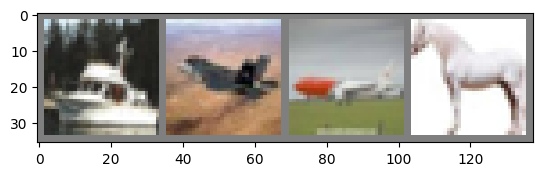

Labels: ship  plane plane horse


In [18]:
# Define a function to display images
def imshow(img):
    # Unnormalize the image
    # The normalization was done using this formula:
    # img_norm = (img - mean) / std
    # So we unnormalize as follows:
    img = img * 0.5 + 0.5

    npimg = img.numpy()

    #The image array is typically stored in the order [height, width, channels],
    #but the plt.imshow function expects the image array to be stored in the
    #order [channels, width, height].
    #The np.transpose function transposes the image array,
    #so that it is stored in the correct order.
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    # Display the image
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show the images using the imshow function
imshow(torchvision.utils.make_grid(images))

# Print labels
print('Labels:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### **TODO 8:**

Implement a simple CNN model with the architecure defined in the comments to classify images from the CIFAR-10 dataset. The CIFAR-10 dataset comprises 3x32x32 pixel RGB color images with 10 distinct categories.

In [19]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # conv1: 3 input channels (RGB), 6 output channels, kernel size 5x5
        # This layer learns 6 different spatial filters simultaneously.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)

        # maxpool: kernel size 2x2 and stride 2
        # Reduces spatial resolution by half (e.g., 28x28 -> 14x14).
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # conv2: 6 input channels, 16 output channels, kernel size 5x5
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        # fc1: 16*5*5 input features, 120 output features
        # Why 16*5*5?
        # Input: 32x32 -> conv1 (5x5, no pad): 28x28 -> pool (2x2): 14x14
        # Next: 14x14 -> conv2 (5x5, no pad): 10x10 -> pool (2x2): 5x5
        # Channels end at 16, so flattened total = 16 * 5 * 5 = 400
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)

        # fc2: 120 input features, 84 output features
        self.fc2 = nn.Linear(in_features=120, out_features=84)

        # fc3: 84 input features, 10 output features (for CIFAR-10 classes)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # 1. First Conv -> ReLU -> Pool
        # ReLU introduces non-linearity (essential for learning complex patterns).
        x = self.pool(F.relu(self.conv1(x)))

        # 2. Second Conv -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x)))

        # 3. Flattening for Fully Connected (FC) Layers
        # Reshapes from (Batch, 16, 5, 5) to (Batch, 400).
        # Flattening starts from dimension 1 to preserve the Batch dimension at index 0.
        x = torch.flatten(x, 1)

        # 4. First FC -> ReLU
        x = F.relu(self.fc1(x))

        # 5. Second FC -> ReLU
        x = F.relu(self.fc2(x))

        # 6. Third FC (Output Layer)
        # No ReLU here; raw logits are used for CrossEntropyLoss (which applies Softmax).
        x = self.fc3(x)

        return x
net = Net().to(device)

### **TODO 9:**

Implement the training loop for your CNN model. The loop should feed input data to the model, compute the loss using the correct labels, and update the model weights using an optimization algorithm.

In [20]:

# Skeleton for TODO 9
def train(model: nn.Module, dataloader: DataLoader, epoch_num: int):
    """
    Trains the neural network model using a specified dataloader and number of epochs.
    """
    # Set the model to training mode.
    # Essential for layers like Dropout and BatchNorm to behave correctly.
    model.train()

    # Identify the device (CPU or GPU) where the model parameters reside.
    # Ensures both data and model are on the same compute engine.
    device = next(model.parameters()).device

    # Define the Loss Criterion and Optimizer.
    # CrossEntropyLoss applies LogSoftmax and NLLLoss internally.
    criterion = nn.CrossEntropyLoss()

    # SGD with Momentum helps accelerate gradients in the right direction and dampens oscillations.
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Loop over the dataset multiple times (Epochs)
    for epoch in range(epoch_num):
        running_loss = 0.0

        # Iterate over mini-batches of data
        for i, (inputs, labels) in enumerate(dataloader, 0):
            # Move data to the same hardware device as the model (Host to Device transfer)
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear accumulated gradients from the previous iteration.
            # In PyTorch, gradients accumulate by default (useful for RNNs or large virtual batches).
            optimizer.zero_grad()

            # 1. Forward pass: Compute predicted outputs by passing inputs to the model
            outputs = model(inputs)

            # 2. Compute Loss: Quantify the error between predictions and ground truth
            loss = criterion(outputs, labels)

            # 3. Backward pass: Use autograd to compute gradients of the loss w.r.t. parameters
            loss.backward()

            # 4. Optimization: Update weights based on the computed gradients and SGD logic
            optimizer.step()

            # Statistics tracking
            running_loss += loss.item()
            # Print average loss every 2000 mini-batches
            if i % 2000 == 1999:
                print(f'[Epoch: {epoch + 1}, Batch: {i + 1:5d}] Loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')

Train this CNN on the training dataset with 2 epochs (this may take a few moments).

In [21]:
train(net, trainloader, 2)

[Epoch: 1, Batch:  2000] Loss: 2.240
[Epoch: 1, Batch:  4000] Loss: 1.918
[Epoch: 1, Batch:  6000] Loss: 1.745
[Epoch: 1, Batch:  8000] Loss: 1.631
[Epoch: 1, Batch: 10000] Loss: 1.561
[Epoch: 1, Batch: 12000] Loss: 1.494
[Epoch: 2, Batch:  2000] Loss: 1.436
[Epoch: 2, Batch:  4000] Loss: 1.398
[Epoch: 2, Batch:  6000] Loss: 1.367
[Epoch: 2, Batch:  8000] Loss: 1.337
[Epoch: 2, Batch: 10000] Loss: 1.322
[Epoch: 2, Batch: 12000] Loss: 1.297
Finished Training


Having successfully trained our CNN, it's now time to evaluate its generalization performance on new, unseen data. We'll do this by selecting a few sample images from our test dataset.

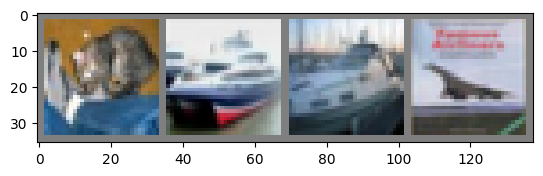

GroundTruth:  cat   ship  ship  plane
Predicted:  cat   ship  ship  plane


In [22]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

net = net.to(device)
net.eval()
images = images.to(device)
with torch.no_grad():
    outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j].item()]:5s}'
                              for j in range(4)))

### **TODO 10:**

In the following code cell, implement a function that measures classification accuracy of the provided neural network model using the entire test dataset. This function should calculate and return the percentage of correctly predicted samples in the test dataset.

In [23]:

# Skeleton for TODO 10
def calculate_accuracy(model: nn.Module, dataloader: DataLoader) -> float:
    """
    Evaluate the classification accuracy of a neural network model on a given test dataset.
    """
    correct_predictions = 0
    total_samples = 0

    # Set the model to evaluation mode.
    # This deactivates Dropout and ensures BatchNorm uses running statistics.
    model.eval()

    # Identify the device where the model is currently located.
    device = next(model.parameters()).device

    # Disable gradient calculations to save memory and compute cycles.
    # During inference, we don't need to store the computational graph for backprop.
    with torch.no_grad():
        for inputs, labels in dataloader:
            # Transfer data to the designated compute engine (Host to Device).
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass: execute the trained weights on new data.
            outputs = model(inputs)

            # Find the class index with the highest logit score.
            # dim=1 refers to the class dimension (10 classes for CIFAR-10).
            _, predicted = torch.max(outputs.data, 1)

            # Increment the total count by the batch size.
            total_samples += labels.size(0)

            # Accumulate the count of correct predictions.
            correct_predictions += (predicted == labels).sum().item()

    # Calculate and return the final accuracy percentage.
    accuracy = 0.0
    if total_samples > 0:
        accuracy = 100.0 * correct_predictions / total_samples

    return accuracy

### **TODO 11:**

Apply filter decomposition to the first convolutional layer of a neural network in PyTorch. The original layer is defined as a 5x5 convolution, and we will decompose it into two layers with 3x3 and 3x3 filters. The intermediate output channel is 3. Train the model and evaluate the accuracy.

In [24]:
# Skeleton for TODO 11
net = Net().to(device)

# replace the first conv by two conv layers
net.conv1 = nn.Sequential(
    # 3 input channels, 3 output channels, kernel size 3x3
    nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3),

    # Optionally, you could add a non-linearity here like nn.ReLU()
    # to increase model capacity, but we'll stick to the exact prompt skeleton:

    # 3 input channels, 6 output channels, kernel size 3x3
    nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)
)

net = net.to(device)

# train the model and evaluate the accuracy
# (Assuming trainloader, testloader, train, and calculate_accuracy are already defined)
train(net, trainloader, 2)
accuracy_score = calculate_accuracy(net, testloader)
print(f'Accuracy of the network on the test images: {accuracy_score:.2f}%')

[Epoch: 1, Batch:  2000] Loss: 2.271
[Epoch: 1, Batch:  4000] Loss: 2.006
[Epoch: 1, Batch:  6000] Loss: 1.843
[Epoch: 1, Batch:  8000] Loss: 1.701
[Epoch: 1, Batch: 10000] Loss: 1.610
[Epoch: 1, Batch: 12000] Loss: 1.556
[Epoch: 2, Batch:  2000] Loss: 1.458
[Epoch: 2, Batch:  4000] Loss: 1.416
[Epoch: 2, Batch:  6000] Loss: 1.386
[Epoch: 2, Batch:  8000] Loss: 1.336
[Epoch: 2, Batch: 10000] Loss: 1.315
[Epoch: 2, Batch: 12000] Loss: 1.252
Finished Training
Accuracy of the network on the test images: 55.54%


### **TODO 12:**

Apply filter decomposition to the first convolutional layer of a neural network in PyTorch. The original layer is defined as a 5x5 convolution, and we will decompose it into two layers with 5x1 and 1x5 filters. The intermediate output channel is 3. Train the model and evaluate the accuracy.

In [25]:

# Skeleton for TODO 12
net = Net().to(device)

# replace the first conv by two conv layers
net.conv1 = nn.Sequential(
    # 3 input channels, 3 output channels, kernel size 5x1
    # 這裡的 kernel_size=(5, 1) 代表高度為 5，寬度為 1
    nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(5, 1)),

    # 3 input channels, 6 output channels, kernel size 1x5
    # 這裡的 kernel_size=(1, 5) 代表高度為 1，寬度為 5
    nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(1, 5))
)

net = net.to(device)

# train the model and evaluate the accuracy
# 假設 trainloader, testloader, train, 以及 calculate_accuracy 都已經定義好
train(net, trainloader, 2)
accuracy_score = calculate_accuracy(net, testloader)
print(f'Accuracy of the network on the test images: {accuracy_score:.2f}%')

[Epoch: 1, Batch:  2000] Loss: 2.239
[Epoch: 1, Batch:  4000] Loss: 1.978
[Epoch: 1, Batch:  6000] Loss: 1.833
[Epoch: 1, Batch:  8000] Loss: 1.706
[Epoch: 1, Batch: 10000] Loss: 1.649
[Epoch: 1, Batch: 12000] Loss: 1.595
[Epoch: 2, Batch:  2000] Loss: 1.516
[Epoch: 2, Batch:  4000] Loss: 1.466
[Epoch: 2, Batch:  6000] Loss: 1.432
[Epoch: 2, Batch:  8000] Loss: 1.424
[Epoch: 2, Batch: 10000] Loss: 1.400
[Epoch: 2, Batch: 12000] Loss: 1.377
Finished Training
Accuracy of the network on the test images: 52.11%


### **TODO 13:**
1. In the CNN model we have created, how many layers have trainable weights? Please list all the dimensions of each layer's weights.

2. For each of the layers with traiable weights, please list their input and output dimension.

3. The outputs of a neural network before the activation function is applied are named as "logits". For multi-class clasification, we know that we need to apply softmax activation function to logits and then compute cross-entropy loss on it. However, in our `Net` class where we define the model architecture, we haven't explicitly initialized a softmax function or applied it to the model's final output within the forward function. Can you explain why by referring to PyTorch's [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) documentation?

4. How does the softmax function simplify to the logistic (sigmoid) function when the number of classes is 2?

5. Why is cross-entropy loss prefered over MSE loss for multi-class classification?

6. Suppose we have a vector of logits `Z`, with a dimension of `M`. This dimension corresponds to the number of output classes in a classification task, such as the Cifar10 classification task where `M` = 10. First, we apply the softmax function to the logits `Z`, which yields a vector of predicted probabilities for each class, denoted as `P`. Then, we compute the cross-entropy loss, denoted as `L`, using the probabilities vector `P` and the true class labels `Y`, which are provided in the form of a one-hot encoded vector of the same length `M`. Derive the gradient of the loss `L` with respect to the logits `Z`, namely `dL/dZ`.

### Your answers for TODO 13

1. 5 layer(2 conv+ 3 fc)

conv1 :Weight: $(6, 3, 5, 5)$ Bias: $(6)$ con2 Weight: $(16, 6, 5, 5)$ Bias: $(16)$
fc1 Weight: $(120, 400)$ Bias: $(120)$ fc2 Weight: $(84, 120)$ Bias: $(84)$ fc3 Weight: $(10, 84)$ Bias: $(10)$

2. Input and Output Dimensions per LayerAssuming an input batch size of $N$ and original $32 \times 32$ RGB images:conv1: Input: $(N, 3, 32, 32) \rightarrow$ Output: $(N, 6, 28, 28)$conv2: (After $2 \times 2$ MaxPool, dimensions become $14 \times 14$)Input: $(N, 6, 14, 14) \rightarrow$ Output: $(N, 16, 10, 10)$fc1: (After the second MaxPool, dimensions become $5 \times 5$, then flattened)Input: $(N, 400) \rightarrow$ Output: $(N, 120)$fc2: Input: $(N, 120) \rightarrow$ Output: $(N, 84)$fc3: Input: $(N, 84) \rightarrow$ Output: $(N, 10)$

3. It expects "raw," unscaled Logits from the last layer. Applying a Softmax in the forward function before passing it to CrossEntropyLoss is mathematically incorrect (it performs the probability conversion twice) and breaks PyTorch's internal Log-Sum-Exp optimizations designed for numerical stability.


4. Suppose we have two classes with logits $Z_1$ and $Z_2$. For Class 1, the Softmax probability is:$$\begin{equation}P_1 = \frac{e^{Z_1}}{e^{Z_1} + e^{Z_2}}\end{equation}$$Dividing the numerator and denominator by $e^{Z_1}$:$$\begin{equation}P_1 = \frac{1}{1 + \frac{e^{Z_2}}{e^{Z_1}}} = \frac{1}{1 + e^{-(Z_1 - Z_2)}}\end{equation}$$If we let $Z = Z_1 - Z_2$ (the difference between the logits), the formula becomes exactly the standard Logistic (Sigmoid) function:$$\begin{equation}P_1 = \frac{1}{1 + e^{-Z}}\end{equation}$$

5. Vanishing Gradient: With MSE + Softmax, if the model is confidently wrong (e.g., predicting $\sim 1$ when the label is $0$), the Softmax derivative approaches $0$. This results in a tiny gradient, meaning the model stops learning. Cross-Entropy's logarithm cancels out the Softmax exponent, creating a linear gradient proportional to the error $(P - Y)$, allowing for much faster learning.Non-convexity: For classification tasks, the MSE Loss landscape is non-convex, meaning it contains many local minima where optimization can get stuck. Cross-Entropy + Softmax forms a convex function, mathematically guaranteeing that gradient descent can find the global optimum.

6. Using the Chain Rule, we can derive the gradient step-by-step.Define Softmax:$$\begin{equation}P_i = \frac{e^{Z_i}}{\sum_{k} e^{Z_k}}\end{equation}$$Define Cross-Entropy:$$\begin{equation}L = - \sum_{j=1}^{M} Y_j \log(P_j)\end{equation}$$Goal: Find $\frac{\partial L}{\partial Z_i}$ applying the chain rule:$$\begin{equation}\frac{\partial L}{\partial Z_i} = \sum_{j=1}^{M} \frac{\partial L}{\partial P_j} \frac{\partial P_j}{\partial Z_i}\end{equation}$$Derivative of the loss with respect to probability:$$\begin{equation}\frac{\partial L}{\partial P_j} = -\frac{Y_j}{P_j}\end{equation}$$Softmax Derivatives:If $i = j$:$$\begin{equation}\frac{\partial P_i}{\partial Z_i} = P_i(1-P_i)\end{equation}$$If $i \neq j$:$$\begin{equation}\frac{\partial P_j}{\partial Z_i} = -P_j P_i\end{equation}$$Substituting these back and simplifying using the fact that $\sum Y_j = 1$ (since the ground truth is a one-hot vector):$$\begin{equation}\frac{\partial L}{\partial Z_i} = P_i - Y_i\end{equation}$$
